In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from time import time
from tqdm import tqdm
import jax
import jax.numpy as jnp

from picard import amari_distance
from multiviewica_delay import permica, multiviewica_delay

from apply_dilations_shifts import apply_dilations_shifts
from generate_data import generate_data
from plot_functions import plot_sources_2d, plot_sources_3d, scatter_plot_shifts_or_dilations, plot_params_across_iters, plot_sources_3_steps, plot_amari_across_iters
from other_functions import compute_lambda, Memory_callback
from permica_preprocessing import find_delays_permica, _find_ordering, find_order, find_sign
from lbfgsb_loss_and_grad import loss

In [2]:
jax.config.update('jax_enable_x64', True)

# parameters

In [3]:
m = 10
p = 5
n = 600
max_shift = 0.05
max_dilation = 1.15
bounds_factor = 1.2
noise_data = 0.01
noise_model = 1  # 1 by default
S1_S2_scale = 0.7  # 1 for first function, 0 for second function, 0.5 (for example) for a mixture of both
n_bins = 10  # should divide n
freq_level = 50
number_of_filters_squarenorm_f = 0
filter_length_squarenorm_f = 3
use_envelop_term = True
number_of_filters_envelop = 1
filter_length_envelop = 10
compute_shift_dilation_scale_hessian = True
W_scale = 3
random_state = 3661
n_concat = 3  # should divide n

In [4]:
rng = np.random.RandomState(random_state)

# generate data

In [5]:
X_list, A_list, dilations, shifts, S_list, S = generate_data(
    m=m,
    p=p,
    n=n,
    max_shift=max_shift,
    max_dilation=max_dilation,
    noise_data=noise_data,
    n_bins=n_bins,
    freq_level=freq_level,
    S1_S2_scale=S1_S2_scale,
    rng=rng,
    n_concat=n_concat,
)

# plot true sources

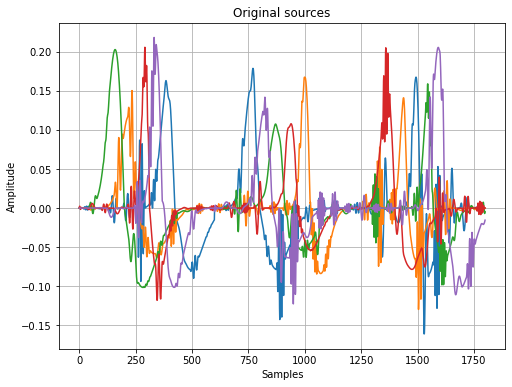

In [6]:
plot_sources_2d(S)

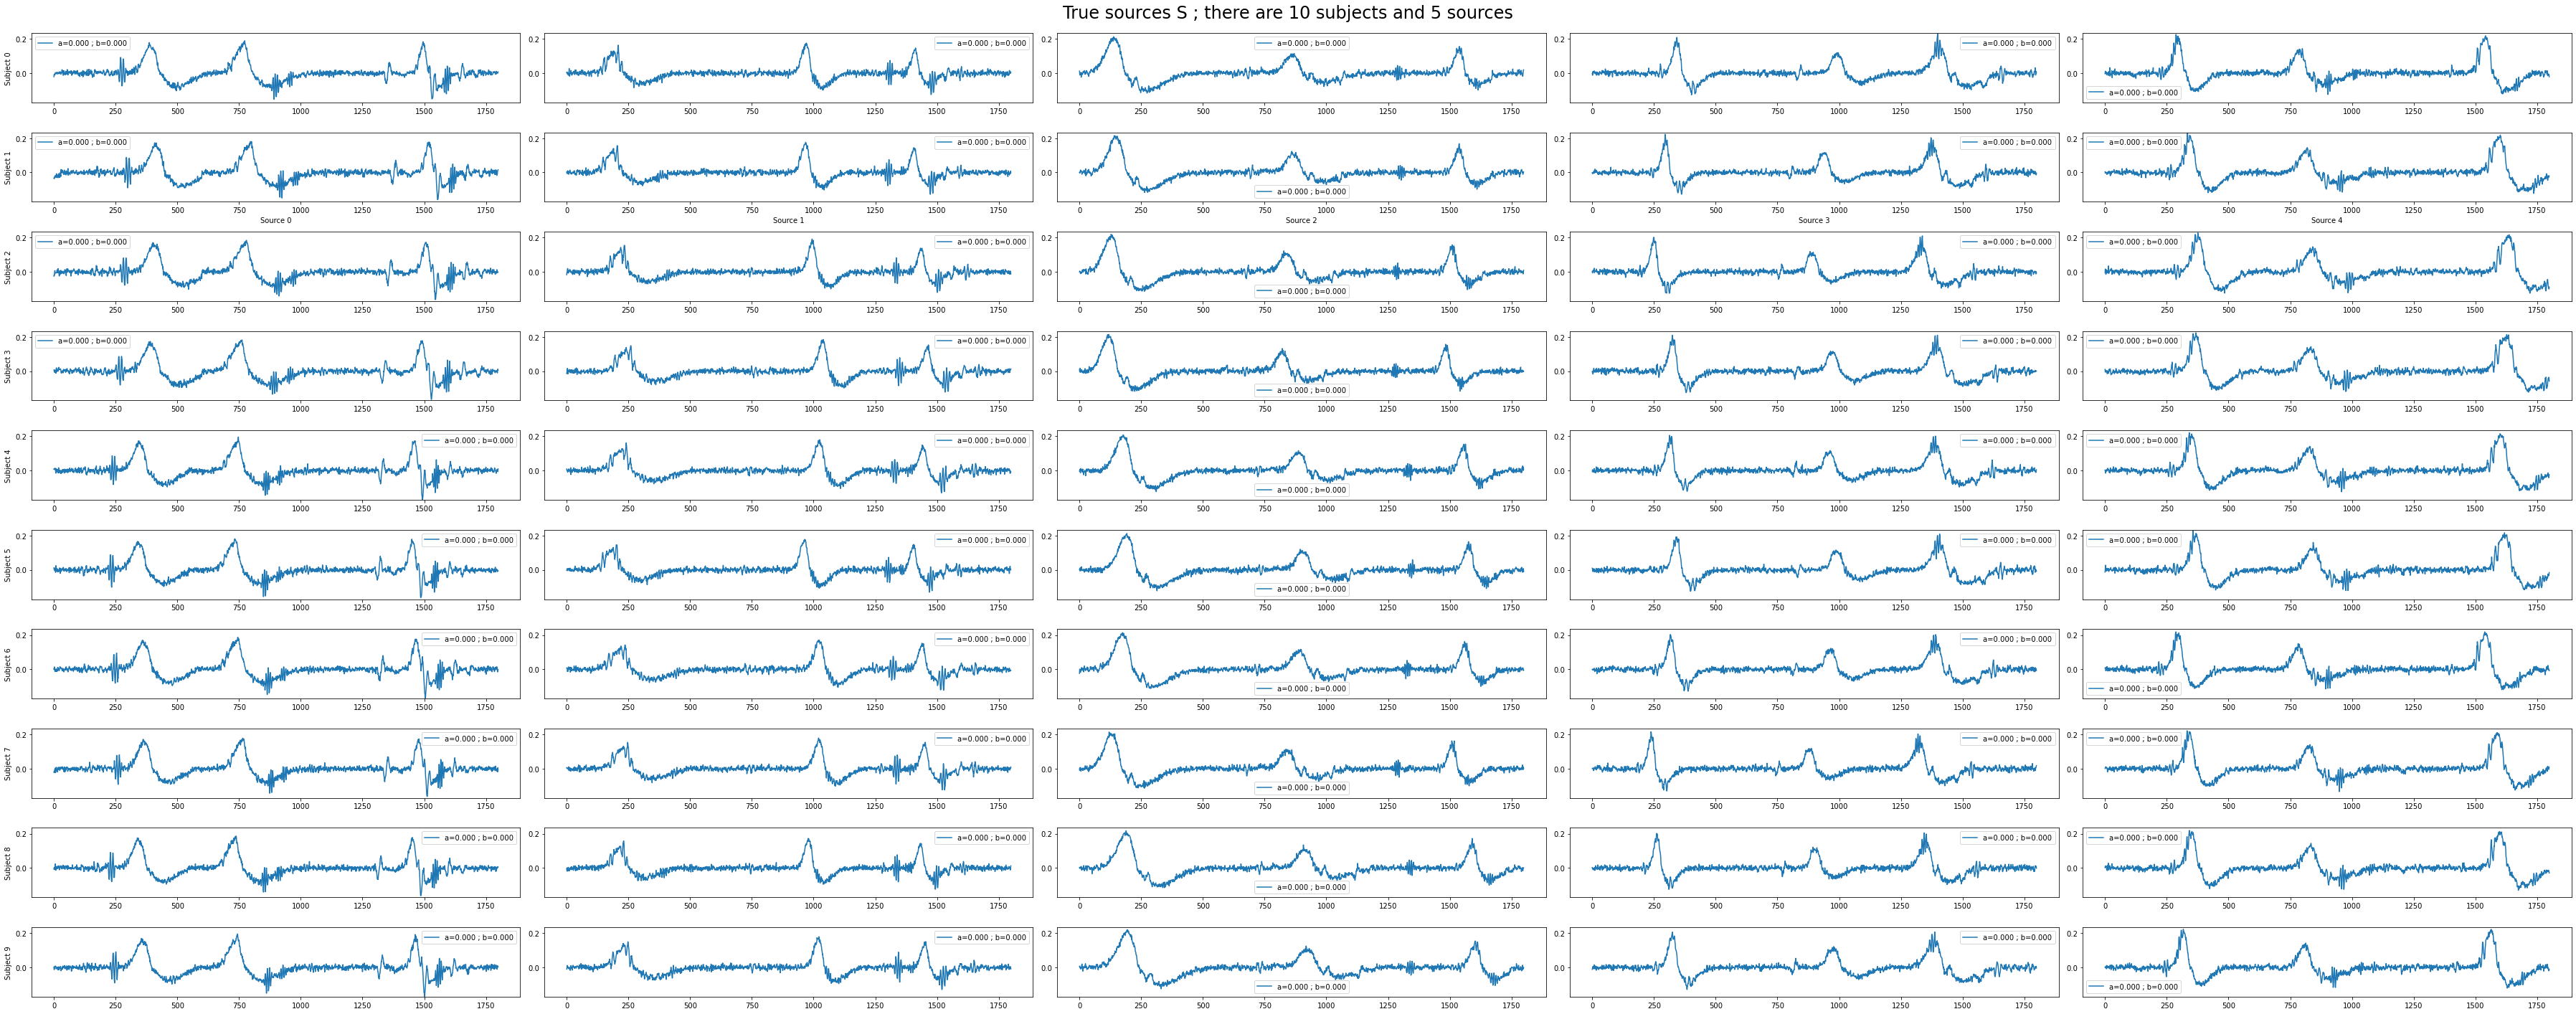

In [7]:
plot_sources_3d(S_list)

# shift scale and dilation scale

In [8]:
shift_scale = W_scale / max_shift  # scalar
dilation_scale = W_scale / (max_dilation - 1)  # scalar
if compute_shift_dilation_scale_hessian:
    lambdas = np.array([[compute_lambda(s, n_concat=n_concat) for s in S] for S in S_list])
    dilation_scale *= lambdas  # (m, p) matrix

In [9]:
max_dilation_2 = 1 + bounds_factor * (max_dilation - 1)
max_shift_2 = bounds_factor * max_shift

# initialize W, dilations and shifts

In [10]:
# initialize W_list and S_list with permica
max_delay = (1 + max_shift) * max_dilation - 1
max_delay_samples = np.ceil(max_delay * n).astype("int")
_, W_list_init, _, _ = permica(
    X_list, max_iter=2000, random_state=random_state, tol=1e-9,
    optim_delays=True, max_delay=max_delay_samples)
S_list_init = np.array([np.dot(W, X) for W, X in zip(W_list_init, X_list)])

In [11]:
# find sources' order for each subject by allowing sources to be delayed
find_delays_order_permica = True
if find_delays_order_permica:
    _, S_list_init = find_delays_permica(S_list_init, max_delay_samples, delay_step=50)
    orders, signs, _ = _find_ordering(S_list_init)
    for i, (order, sign) in enumerate(zip(orders, signs)):
        W_list_init[i] = sign[:, None] * W_list_init[i][order, :]
    S_list_init = np.array([np.dot(W, X) for W, X in zip(W_list_init, X_list)])

100%|██████████| 3125/3125 [00:00<00:00, 10845.73it/s]


In [12]:
# find the order that aligns S_list and S_list_init
order_S_list_S_list_init = True
if order_S_list_S_list_init:
    order = find_order(np.mean(S_list, axis=0), np.mean(S_list_init, axis=0))
    W_list_init = W_list_init[:, order, :]
    S_list_init = S_list_init[:, order, :]
signs_S_list_init = True
if signs_S_list_init:
    signs = find_sign(S_list_init)
    W_list_init *= np.repeat(signs, p, axis=1).reshape(m, p, p)
    S_list_init *= np.repeat(signs, n_concat*n, axis=1).reshape(m, p, n_concat*n)

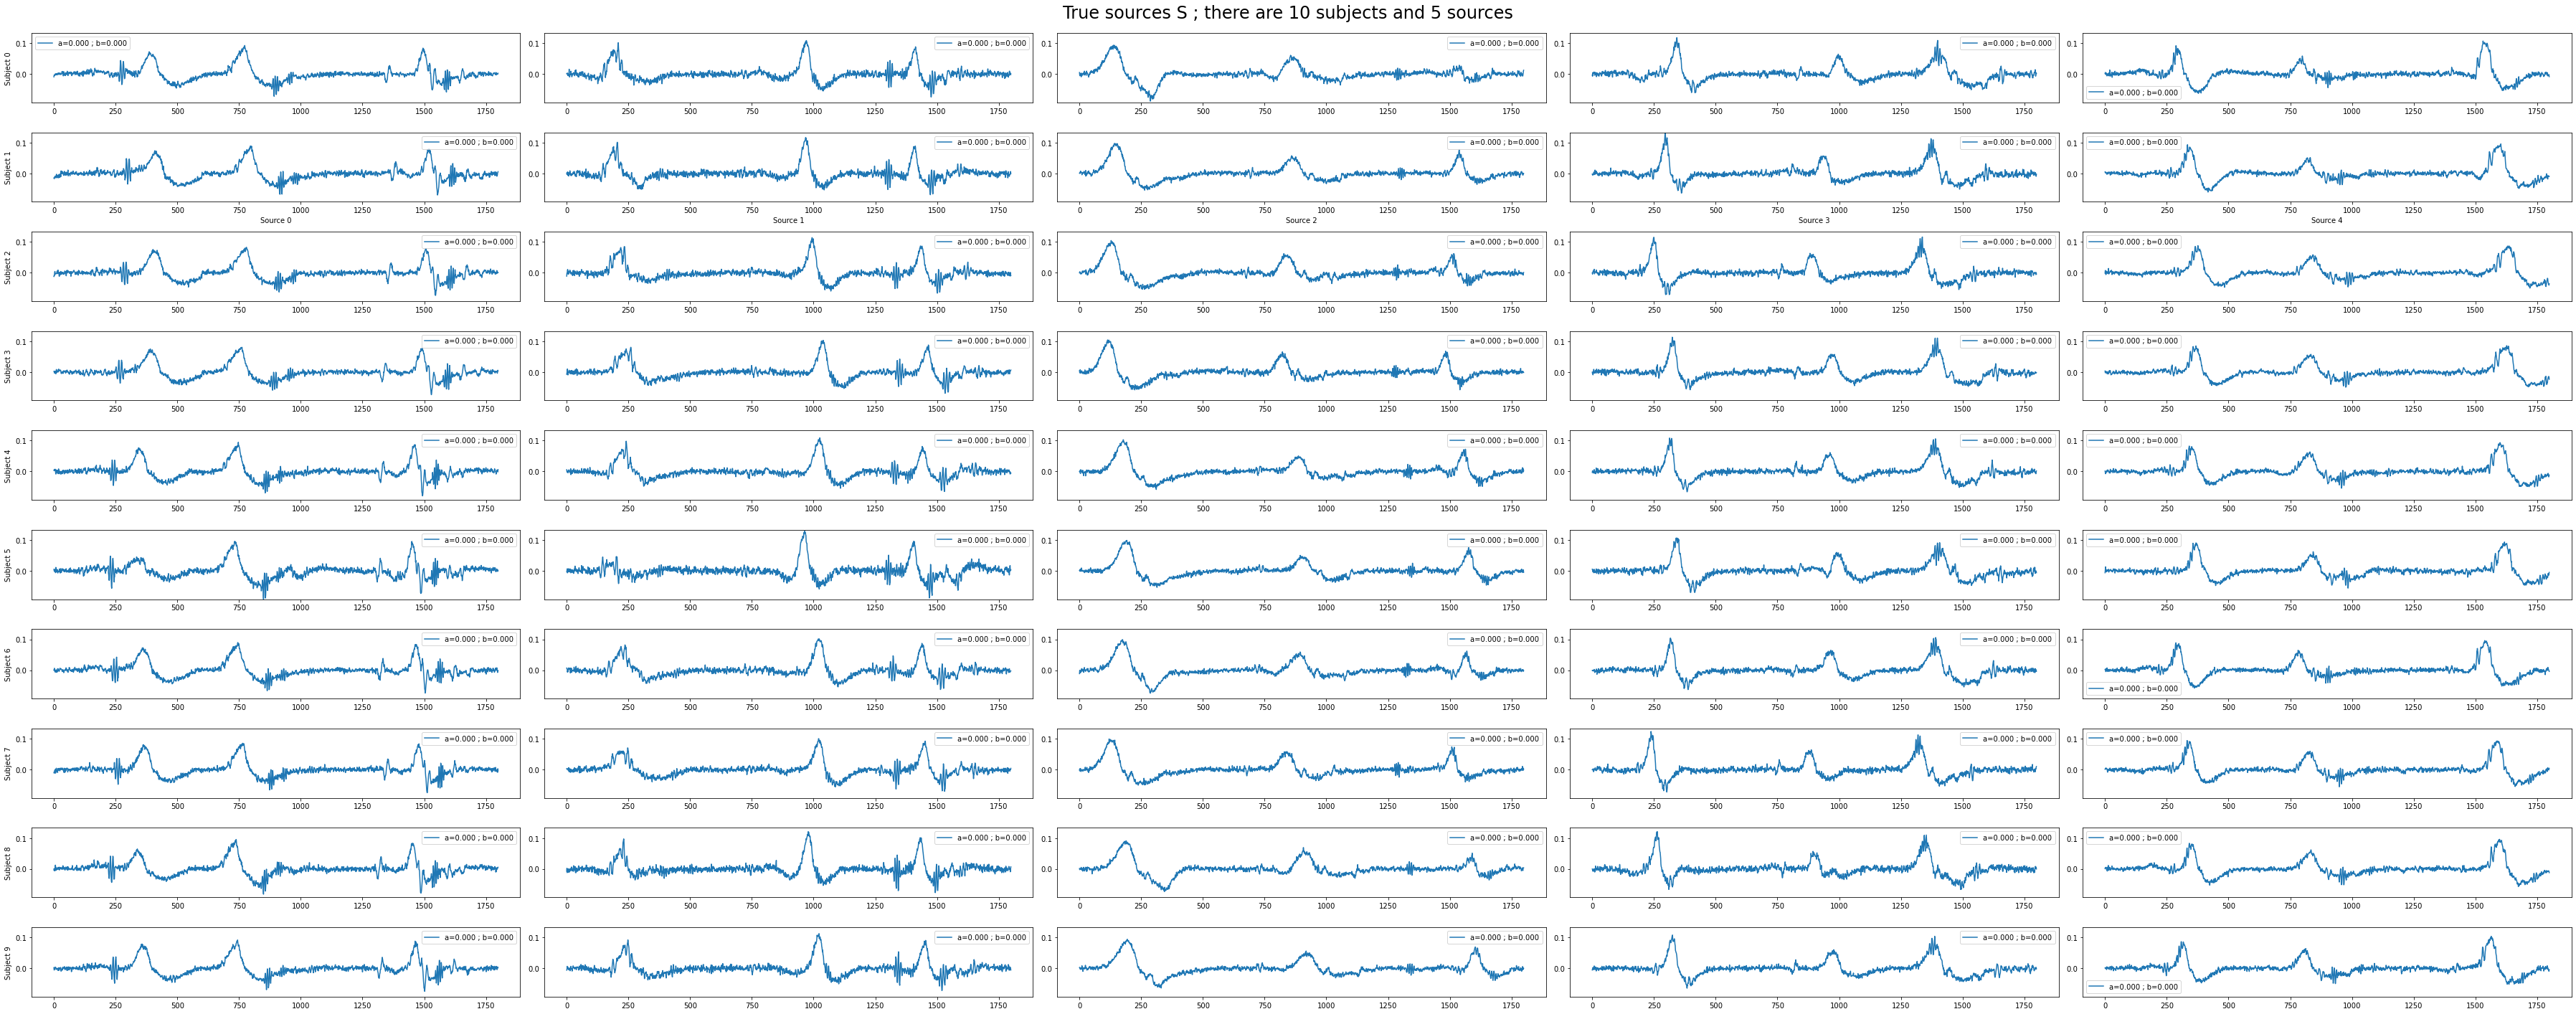

In [13]:
plot_sources_3d(S_list_init)

In [14]:
# Amari distance at init
amari_init = np.mean([amari_distance(W, A) for W, A in zip(W_list_init, A_list)])
print(f"Amari distance after permica : {amari_init}")

Amari distance after permica : 0.05335994325721628


In [15]:
# initialize A and B
A_init = jnp.ones((m, p)) * dilation_scale
B_init = jnp.zeros((m, p))
W_A_B_init = jnp.concatenate([jnp.ravel(W_list_init), jnp.ravel(A_init), jnp.ravel(B_init)])

# jit

In [16]:
args = (
    W_A_B_init,
    X_list,
    dilation_scale,
    shift_scale,
    max_shift_2,
    max_dilation_2,
    noise_model,
    number_of_filters_envelop,
    filter_length_envelop,
    number_of_filters_squarenorm_f,
    filter_length_squarenorm_f,
    use_envelop_term,
    n_concat,
)

In [17]:
# arguments 1 and 2 have to be static because they are np.ndarray
val_and_grad = jax.jit(jax.value_and_grad(loss), static_argnums=tuple(np.arange(3, 13)))

I don't know why but defining val_and_grad like this:

def val_and_grad(*args):
    return jax.jit(jax.value_and_grad(loss), static_argnums=tuple(np.arange(3, 13)))(*args)

makes wrapper_loss_and_grad(*args) far slower.

In [18]:
def wrapper_loss_and_grad(*args):
    val, grad = val_and_grad(*args)
    return val, np.array(grad)

def jit_wrapper(*args):
    print("Jit...")
    start = time()
    wrapper_loss_and_grad(*args)
    print(f"Jit time : {time() - start}")

In [19]:
loss(*args)

Array(55.4371545, dtype=float64)

In [20]:
jit_wrapper(*args)

Jit...
Jit time : 102.67169213294983


In [40]:
n_iters = 10
time_loss = []
time_loss_and_grad = []
args = list(args)
for i in tqdm(range(n_iters)):
    # initialize W, A and B
    W_list_init_test = jnp.array(rng.randn(m, p, p))
    A_init_test = jnp.array(
        rng.uniform(low=1/max_dilation, high=max_dilation, size=(m, p))) * dilation_scale
    B_init_test = jnp.array(rng.uniform(low=-max_shift, high=max_shift, size=(m, p)))
    W_A_B_init_test = jnp.concatenate(
        [jnp.ravel(W_list_init_test), jnp.ravel(A_init_test), jnp.ravel(B_init_test)])
    args[0] = W_A_B_init_test
    # loss (no jit)
    start = time()
    loss(*args)
    time_loss.append(time() - start)
    # loss and grad (jit)
    start = time()
    wrapper_loss_and_grad(*args)
    time_loss_and_grad.append(time() - start)
print(f"Mean execution time loss : {np.mean(time_loss)}")
print(f"Mean execution time loss and grad : {np.mean(time_loss_and_grad)}")

args[0] = W_A_B_init
args = tuple(args)

100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

Mean execution time loss : 0.25059897899627687
Mean execution time loss and grad : 0.02306509017944336


# LBFGSB

In [22]:
# bounds
bounds_W = [(-jnp.inf, jnp.inf)] * (m * p ** 2)
if compute_shift_dilation_scale_hessian:
    bounds_A = [(1/max_dilation_2*dilation_scale.ravel()[i], max_dilation_2*dilation_scale.ravel()[i]) for i in range(m * p)]
else:
    bounds_A = [(1/max_dilation_2*dilation_scale, max_dilation_2*dilation_scale)] * (m * p)
bounds_B = [(-max_shift_2*shift_scale, max_shift_2*shift_scale)] * (m * p)
bounds_W_A_B = jnp.array(bounds_W + bounds_A + bounds_B)

In [23]:
# LBFGSB
callback = Memory_callback(m, p, dilation_scale, shift_scale)

print("LBFGSB...")
start = time()
res = fmin_l_bfgs_b(
    func=wrapper_loss_and_grad,
    x0=args[0],
    args=args[1:],
    bounds=bounds_W_A_B,
    disp=True,
    # factr=1e9,
    factr=1e3,
    # pgtol=1e-8,
    pgtol=1e-5,
    maxiter=3000,
    callback=callback,
)
print(f"LBFGSB time : {time() - start}")

LBFGSB...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          350     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.54372D+01    |proj g|=  8.30559D+00

At iterate    1    f=  3.35575D+01    |proj g|=  2.53577D+00

At iterate    2    f=  1.78840D+01    |proj g|=  1.86854D+00

At iterate    3    f= -4.50815D+00    |proj g|=  1.02330D+00

At iterate    4    f= -2.51308D+01    |proj g|=  6.20325D-01

At iterate    5    f= -4.64004D+01    |proj g|=  3.30531D-01

At iterate    6    f= -6.60182D+01    |proj g|=  1.85553D-01

At iterate    7    f= -6.78859D+01    |proj g|=  8.78053D-01

At iterate    8    f= -8.36299D+01    |proj g|=  3.92589D-01

At iterate    9    f= -9.53359D+01    |proj g|=  4.02578D-01

At iterate   10    f= -9.86759D+01    |proj g|=  8.85643D-01

At iterate   11    f= -1.03500D+02    |proj g|=  6.48335D-01

At iterate   12    f= -1.07823D+02    |proj g|=  4.39704D-01

At iterate   13 

In [24]:
memory_W = np.array(callback.memory_W)
memory_A = np.array(callback.memory_A)
memory_B = np.array(callback.memory_B)

W = memory_W[-1]
A = 1 / memory_A[-1]
B = -memory_B[-1]

# plot dilations and shifts

In [25]:
# center and reduce
dilations_cr = (dilations - np.mean(dilations, axis=0)) / np.std(dilations, axis=0)
shifts_cr = (shifts - np.mean(shifts, axis=0)) / np.std(shifts, axis=0)
A_cr = (A - np.mean(A, axis=0)) / np.std(A, axis=0)
B_cr = (B - np.mean(B, axis=0)) / np.std(B, axis=0)

In [26]:
# errors
errors_A = np.mean((dilations_cr - A_cr) ** 2)
errors_B = np.mean((shifts_cr - B_cr) ** 2)

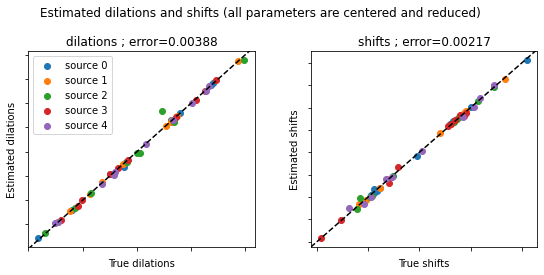

In [27]:
# scatter plots of estimated shifts and dilations
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plt.subplot(1, 2, 1)
scatter_plot_shifts_or_dilations(dilations_cr, A_cr, errors_A, dilations_not_shifts=True, legend=True)
plt.subplot(1, 2, 2)
scatter_plot_shifts_or_dilations(shifts_cr, B_cr, errors_B, dilations_not_shifts=False, legend=False)
plt.suptitle(f"Estimated dilations and shifts (all parameters are centered and reduced)")
plt.tight_layout()
for ax in axes:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()

# zoom on a specific source

In [28]:
source_number = 0

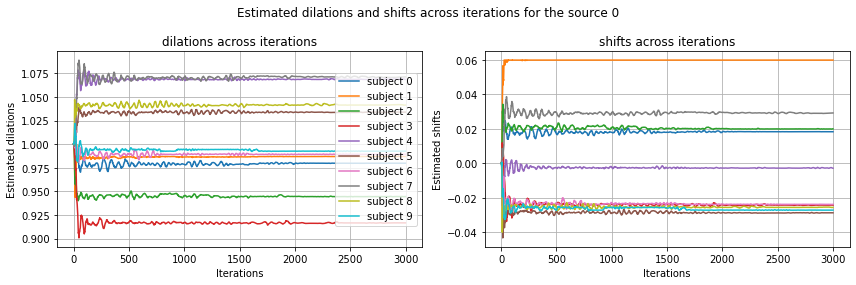

In [29]:
# Estimated dilations and shifts across iterations for one source
plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_params_across_iters(1/memory_A[:, :, source_number], dilations_not_shifts=True, legend=True)
plt.subplot(1, 2, 2)
plot_params_across_iters(-memory_B[:, :, source_number], dilations_not_shifts=False, legend=False)
plt.suptitle(f"Estimated dilations and shifts across iterations for the source {source_number}")
plt.tight_layout()
plt.show()

In [30]:
S_list_lbfgsb_3d = jnp.array([jnp.dot(W_, X) for W_, X in zip(W, X_list)])
S_list_lbfgsb_4d = jnp.swapaxes(jnp.swapaxes(
    jnp.array(jnp.split(S_list_lbfgsb_3d, n_concat, axis=-1)), axis1=0, axis2=1), axis1=1, axis2=2)
Y_list_lbfgsb_4d = apply_dilations_shifts(
    S_list_lbfgsb_4d, dilations=1/A, shifts=-B, max_shift=max_shift_2, 
    max_dilation=max_dilation_2, shift_before_dilation=False)
Y_list_lbfgsb_3d = Y_list_lbfgsb_4d.reshape((m, p, -1))

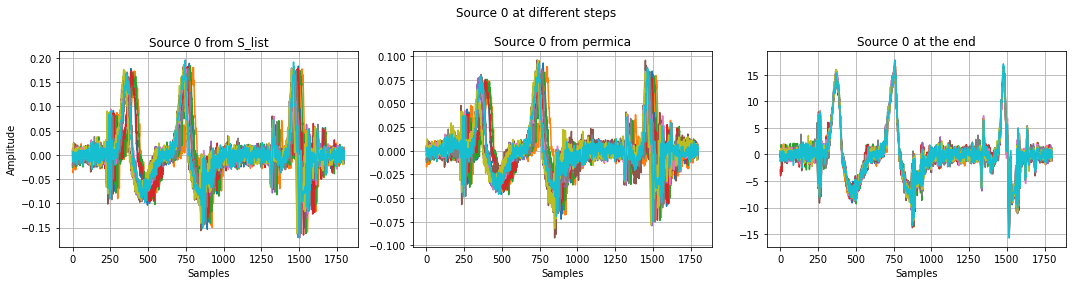

In [31]:
# plot true sources, sources after permica and sources after LBFGSB
plot_sources_3_steps(S_list, S_list_init, Y_list_lbfgsb_3d, source_number=source_number)

# MVICAD

In [32]:
# MVICAD max_delay=max_shift
start = time()
_, W_mvicad, S_mvicad, _, shifts_mvicad, _ = multiviewica_delay(
    X_list,
    init=W_list_init,
    shared_delays=False,
    max_delay=int(max_shift*n),
    random_state=random_state,
    continuous_delays=False,
)
print(f"MVICAD (max_delay={int(max_shift*n)}) time : {time() - start}")
shifts_mvicad[shifts_mvicad > n // 2] -= n
shifts_mvicad_cr = (shifts_mvicad - np.mean(shifts_mvicad, axis=0)) / np.std(shifts_mvicad, axis=0)
error_mvicad = np.mean((shifts_cr - shifts_mvicad_cr) ** 2)

MVICAD (max_delay=30) time : 0.7261362075805664


In [33]:
# MVICAD max_delay=max_delay
start = time()
_, W_mvicad_2, S_mvicad_2, _, shifts_mvicad_2, _ = multiviewica_delay(
    X_list,
    init=W_list_init,
    shared_delays=False,
    max_delay=max_delay_samples,
    random_state=random_state,
    continuous_delays=False,
)
print(f"MVICAD (max_delay={max_delay_samples}) time : {time() - start}")
shifts_mvicad_2[shifts_mvicad_2 > n // 2] -= n
shifts_mvicad_cr_2 = (shifts_mvicad_2 - np.mean(shifts_mvicad_2, axis=0)) / np.std(shifts_mvicad_2, axis=0)
error_mvicad_2 = np.mean((shifts_cr - shifts_mvicad_cr_2) ** 2)

MVICAD (max_delay=125) time : 0.8712530136108398


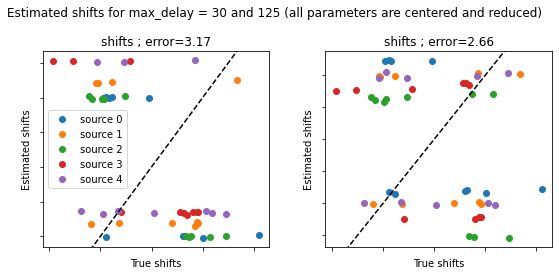

In [34]:
# scatter plots of estimated shifts and dilations
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plt.subplot(1, 2, 1)
scatter_plot_shifts_or_dilations(shifts_cr, shifts_mvicad_cr, error_mvicad, dilations_not_shifts=False, legend=True)
plt.subplot(1, 2, 2)
scatter_plot_shifts_or_dilations(shifts_cr, shifts_mvicad_cr_2, error_mvicad_2, dilations_not_shifts=False, legend=False)
plt.suptitle(f"Estimated shifts for max_delay = {int(max_shift*n)} and {max_delay_samples} (all parameters are centered and reduced)")
plt.tight_layout()
for ax in axes:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()

In [35]:
amari_mvicad = np.mean([amari_distance(W, A) for W, A in zip(W_mvicad, A_list)])
amari_mvicad_2 = np.mean([amari_distance(W, A) for W, A in zip(W_mvicad_2, A_list)])
print(f"Amari distance MVICAD (with max_shift = {int(max_shift*n)}) : {amari_mvicad}")
print(f"Amari distance MVICAD (with max_shift = {max_delay_samples}) : {amari_mvicad_2}")

Amari distance MVICAD (with max_shift = 30) : 0.014211593402481657
Amari distance MVICAD (with max_shift = 125) : 0.004246647431234034


# plot Amari distance

In [36]:
amari_rand = 0
n_iter_rand = 10
for _ in range(n_iter_rand):
    W_list_rand = rng.randn(m, p, p)
    amari_rand += np.mean([amari_distance(W, A) for W, A in zip(W_list_rand, A_list)])
amari_rand /= n_iter_rand
print(f"Amari distance random : {amari_rand}")

Amari distance random : 0.9163490360202022


In [37]:
amari_lbfgsb = [amari_init]
for W_list in tqdm(callback.memory_W):
    amari_lbfgsb.append(np.mean([amari_distance(W, A) for W, A in zip(W_list, A_list)]))

100%|██████████| 3000/3000 [00:01<00:00, 2439.13it/s]


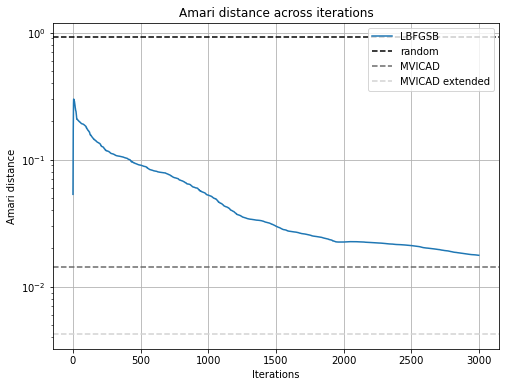

In [38]:
plot_amari_across_iters(amari_lbfgsb, amari_rand, amari_mvicad, amari_mvicad_2)